In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Decission trees

URLs
- https://scikit-learn.org/0.22/auto_examples/tree/plot_cost_complexity_pruning.html 
- [Post Pruning Decision Trees](https://medium.com/swlh/post-pruning-decision-trees-using-python-b5d4bcda8e23)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Load titanic dataset (train dataset only)

In [3]:
data = pd.read_csv('titanic/train.csv')
X, y = data[['Pclass',  
            'Sex', 
            'Age',
            'SibSp',
            'Parch',  
            'Fare',   
            'Cabin',
            'Embarked']], data['Survived']
X,y = X.fillna(0),y.fillna(0)
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

### Overfitting example

In [4]:
model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_predicted = model.predict(X_test)

print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test, y_test))

Training accuracy:  0.9903691813804173
Test Accuracy:  0.7761194029850746


## Post-prunning
- The DecisionTreeClassifier class in sklearn provides **ccp_alpha** as a parameter for post pruning. 
- The parameter ccp_alpha provides a threshold for effective alphas, i.e. the process of pruning continues until the minimal effective alpha of the pruned tree is not greater than ccp_alpha. 
- The DecisionTreeClassifier class also provides a method **cost_complexity_pruning_path** which implements **the pruning process** and returns the effective alphas (and the corresponding impurities of there pruned trees)

{'ccp_alphas': array([0.00000000e+00, 0.00000000e+00, 1.42678794e-04, 1.60513644e-04,
       2.20706260e-04, 2.92491528e-04, 8.02568218e-04, 8.56072766e-04,
       9.87776269e-04, 9.87776269e-04, 1.07009096e-03, 1.07009096e-03,
       1.07796454e-03, 1.25770431e-03, 1.33761370e-03, 1.33761370e-03,
       1.36753400e-03, 1.37583123e-03, 1.37583123e-03, 1.45228841e-03,
       1.47137507e-03, 1.52870137e-03, 1.60513644e-03, 1.68961730e-03,
       1.84732774e-03, 1.91087671e-03, 1.96611572e-03, 2.06374685e-03,
       2.14018192e-03, 2.16271015e-03, 2.24719101e-03, 2.40770465e-03,
       2.46404657e-03, 2.49687890e-03, 2.66260382e-03, 2.88924559e-03,
       2.93970807e-03, 3.04975923e-03, 3.42180248e-03, 3.93188777e-03,
       6.01333133e-03, 6.19679542e-03, 8.64451052e-03, 1.22070626e-02,
       1.27995980e-02, 3.64216439e-02, 1.48693178e-01]), 'impurities': array([0.01139647, 0.01139647, 0.01168183, 0.01184234, 0.01228375,
       0.01257624, 0.01337881, 0.01594703, 0.01891036, 0.02483702,

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

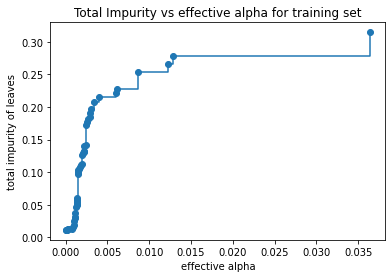

In [5]:
path=DecisionTreeClassifier(random_state=1).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(path)

# plotting
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], 
        impurities[:-1], 
        marker='o', 
        drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [6]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1,ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {} and a depth of: {}".\
      format(clfs[-1].tree_.node_count, ccp_alphas[-1],clfs[-1].tree_.max_depth))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1486931782834916 and a depth of: 0


#### We remove the last element in **clfs** and **ccp_alphas**, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

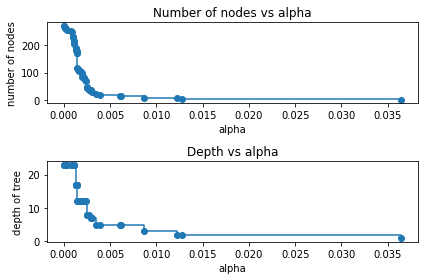

In [7]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

# plotting
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, 
           node_counts, 
           marker='o', 
           drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, 
           depth, 
           marker='o', 
           drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

## Accuracy vs alpha for training and testing sets

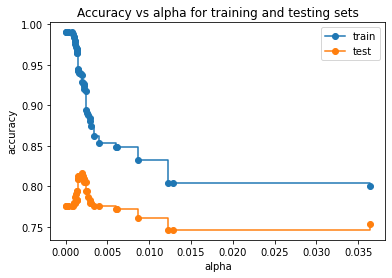

In [8]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# plotting
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")

ax.plot(ccp_alphas, 
        train_scores, 
        marker='o', 
        label="train",
        drawstyle="steps-post")

ax.plot(ccp_alphas, 
        test_scores, 
        marker='o', 
        label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Use the best model

In [9]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]

print('Training accuracy of best model: ', best_model.score(X_train, y_train))
print('Test accuracy of best model: ', best_model.score(X_test, y_test))

Training accuracy of best model:  0.9373996789727127
Test accuracy of best model:  0.8171641791044776
